In [1]:
import os
from typing import List, Tuple, Dict, Union, Optional

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import random
random.seed(2023)

import numpy as np

np.random.seed(2023)  # Set seed for reproducibility
import keras
import tensorflow as tf
from tqdm import tqdm

tf.random.set_seed(2023)
tf.config.run_functions_eagerly(True)
keras.backend.clear_session()
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils import plot_model
from keras.models import load_model
from keras.optimizers import Adam


from archs.segmentation.unet import build_unet
from data.augmentor import Augmentor
from data.data_generator import DataLoader, DataGeneratorAugmented
from uncertainty.monte_carlo_dropout import ModelWithMonteCarlo
from utils.callbacks import PlotMetricsCallback, PlotSampleCallback
from utils.helper import create_dirs, write_setup
from utils.loss import FocalDiceLoss, dice_coef
from utils.visualizations import plot_sample
from data.data_generator import loaders

gen_dir = "/home/thjo/Datasets/Brats/"
fp16 = False
gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print(f"GPU(s) available (using '{gpus[0].name}'). Training will be lightning fast!")
    if fp16:
        details = tf.config.experimental.get_device_details(gpus[0])
        compute_capability = details.get('compute_capability')
        print("Compute capability:", compute_capability)
        if compute_capability[0] > 6:
            print("Turning on mixed_float16")
            policy = tf.keras.mixed_precision.Policy('mixed_float16')
            tf.keras.mixed_precision.set_global_policy(policy)
else:
    print("No GPU(s) available. Training will be suuuuper slow!")


GPU(s) available (using '/physical_device:GPU:0'). Training will be lightning fast!


## Training initialization

In [2]:
array_labels = ['t1', 't1ce', 't2', 'flair', 'mask']
model_name = "unet_final"
model_dir, figure_path, checkpoint_path = create_dirs(model_name)
batch_size = 64
epochs = 40
augment = True
gen_train, gen_val, gen_test, augmentor = loaders(gen_dir, batch_size, augment, array_labels)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min')
plot_metrics_callback = PlotMetricsCallback(epochs=epochs,n_batches=len(gen_train))
plot_sample_callback = PlotSampleCallback(gen_val, figure_path, threshold=0.5, title=f"Validation sample")
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks = [early_stopping, reduce_lr, plot_metrics_callback, plot_sample_callback, checkpoint_callback]

In [3]:
input_shape = (64,64,len(array_labels)-1)
num_classes = 1 # Number of classes is equal to the number of channels in the output
filters = [16,32,64,128,256]
learning_rate = 1e-2
weight_decay = 0
kernel_size = 3
strides = 1
padding = "same"
activation = "relu"
drop_rate_encoder = [0.1]
drop_rate_decoder = [0.1]
depth_encoder = [1,2,3,4]
depth_decoder = [1,1,1]
output_depth = 2
output_activation = "sigmoid"
decoder_type = "concat"
upsample_type = "transposed"
setup = {
    "input_shape": input_shape,
    "num_classes": num_classes,
    "learning_rate": learning_rate,
    "weight_decay": weight_decay,
    "filters": filters,
    "kernel_size": kernel_size,
    "strides": strides,
    "padding": padding,
    "activation": activation,
    "depth_encoder": depth_encoder,
    "decoder_type": decoder_type, # "concat", "add", "noskip"
    "upsample_type": upsample_type, # "transposed", "bilinear", "nearest", "cubic"
    "depth_decoder": depth_decoder,
    "drop_rate_encoder": drop_rate_encoder,
    "drop_rate_decoder": drop_rate_decoder,
    "output_depth": output_depth,
    "output_activation": output_activation,
}
write_setup(model_dir, setup) # Write setup to json file for later reference
loss = FocalDiceLoss(w_focal=0.8, w_dice=0.2, gamma=1.0)
optimizer = Adam(learning_rate=learning_rate,decay=weight_decay)

In [4]:
unet = build_unet(
            input_shape=input_shape,
            num_classes=num_classes,
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            activation=activation,
            depth_encoder=depth_encoder,
            depth_decoder=depth_decoder,
            drop_rate_encoder=drop_rate_encoder,
            drop_rate_decoder=drop_rate_decoder,
            output_depth=output_depth,
            output_activation=output_activation,
            decoder_type=decoder_type,
            upsample_type=upsample_type,
        )
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 4)]  0           []                               
                                                                                                  
 Encoder (Functional)           [(None, 32, 32, 16)  5827520     ['input_2[0][0]']                
                                , (None, 16, 16, 32                                               
                                ),                                                                
                                 (None, 8, 8, 64),                                                
                                 (None, 4, 4, 128),                                               
                                 (None, 2, 2, 256)]                                           

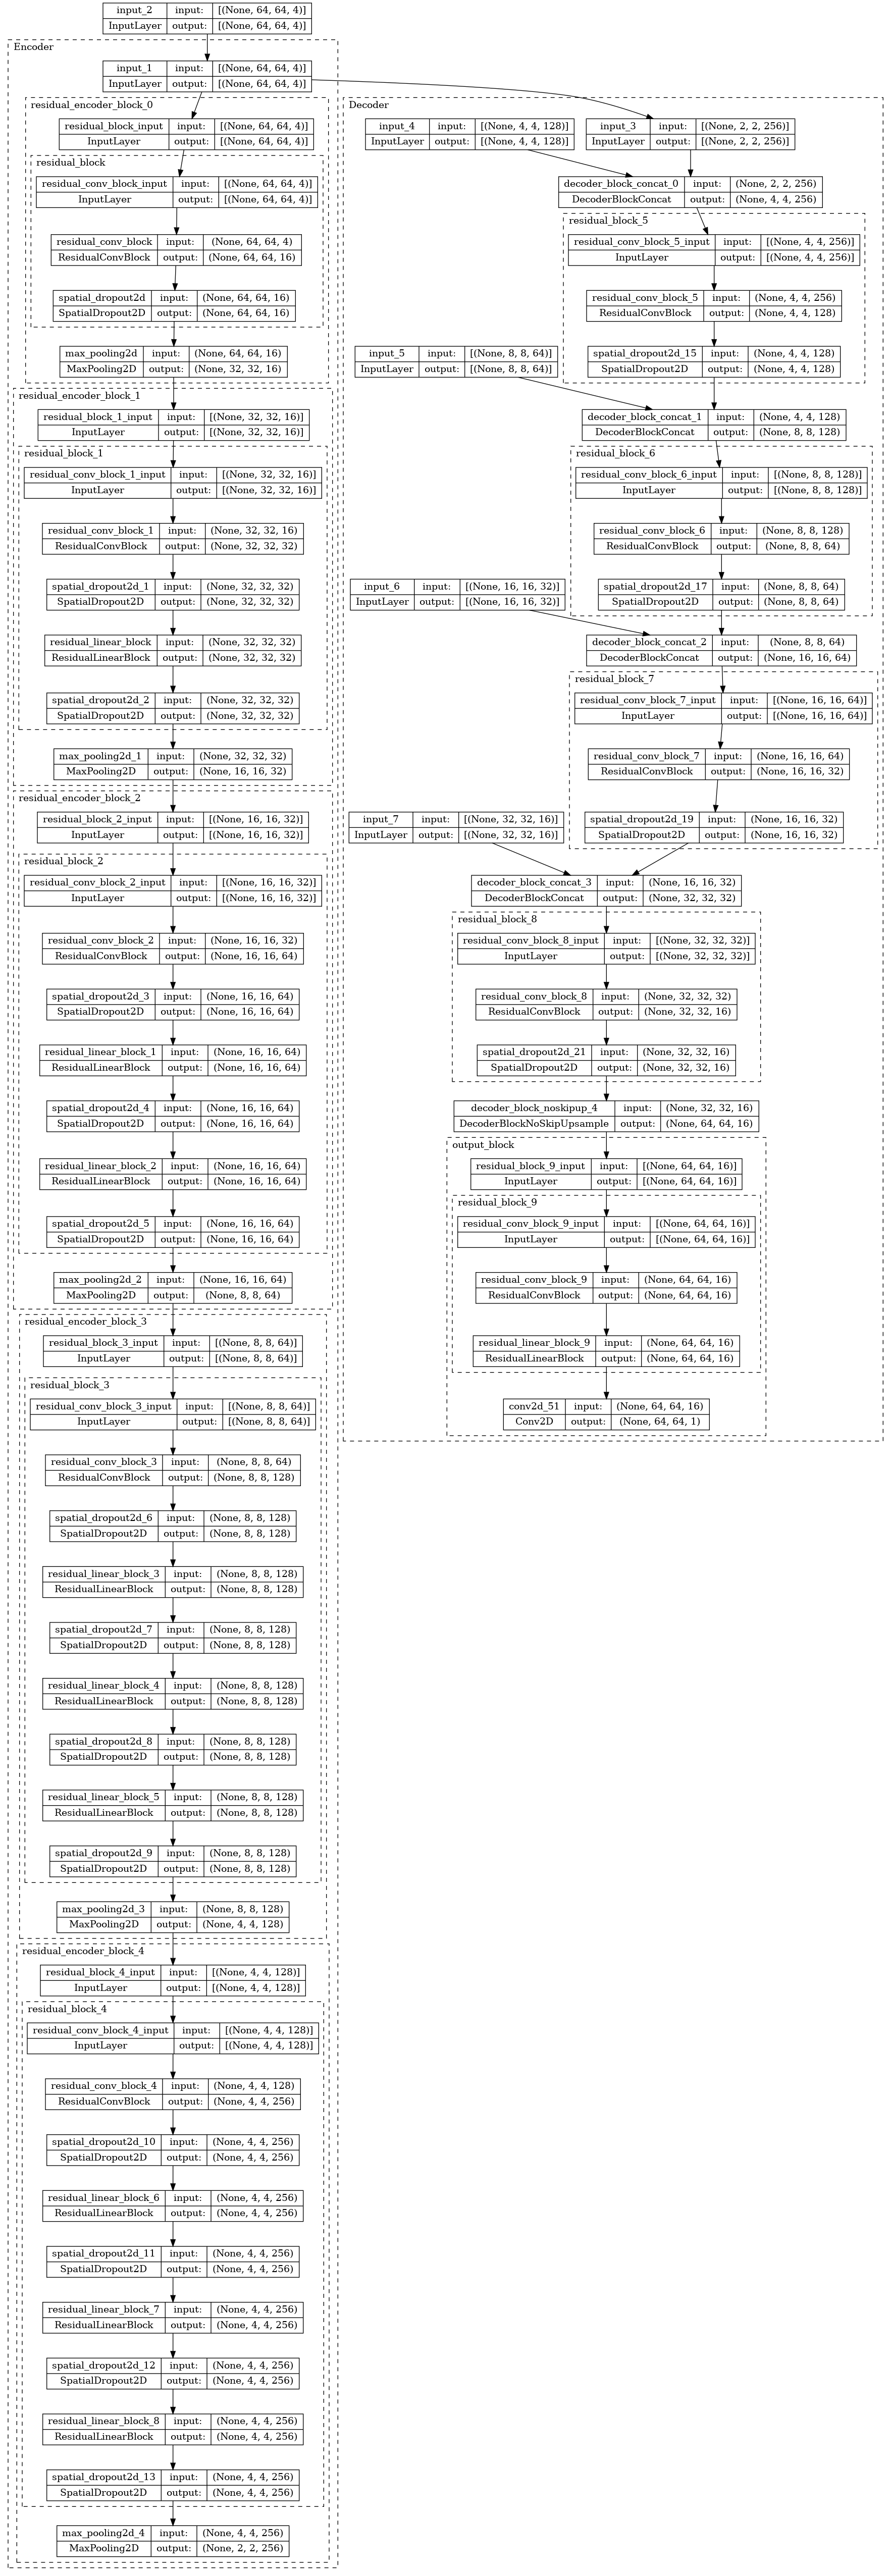

In [7]:
plot_model(unet, show_shapes=True, show_layer_names=True,expand_nested=True)

In [6]:
unet.compile(loss=loss, metrics=dice_coef, optimizer=optimizer)

/home/thjo/miniconda3/envs/tf2/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


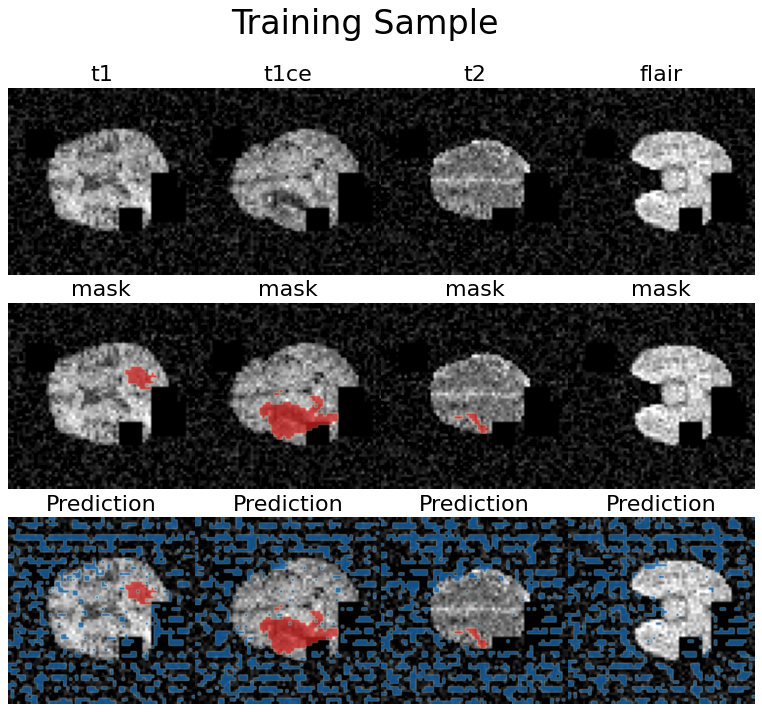

In [7]:
plot_sample(gen_train, array_labels, model=unet, batch_idx=2, save=False, title=f"Training Sample")

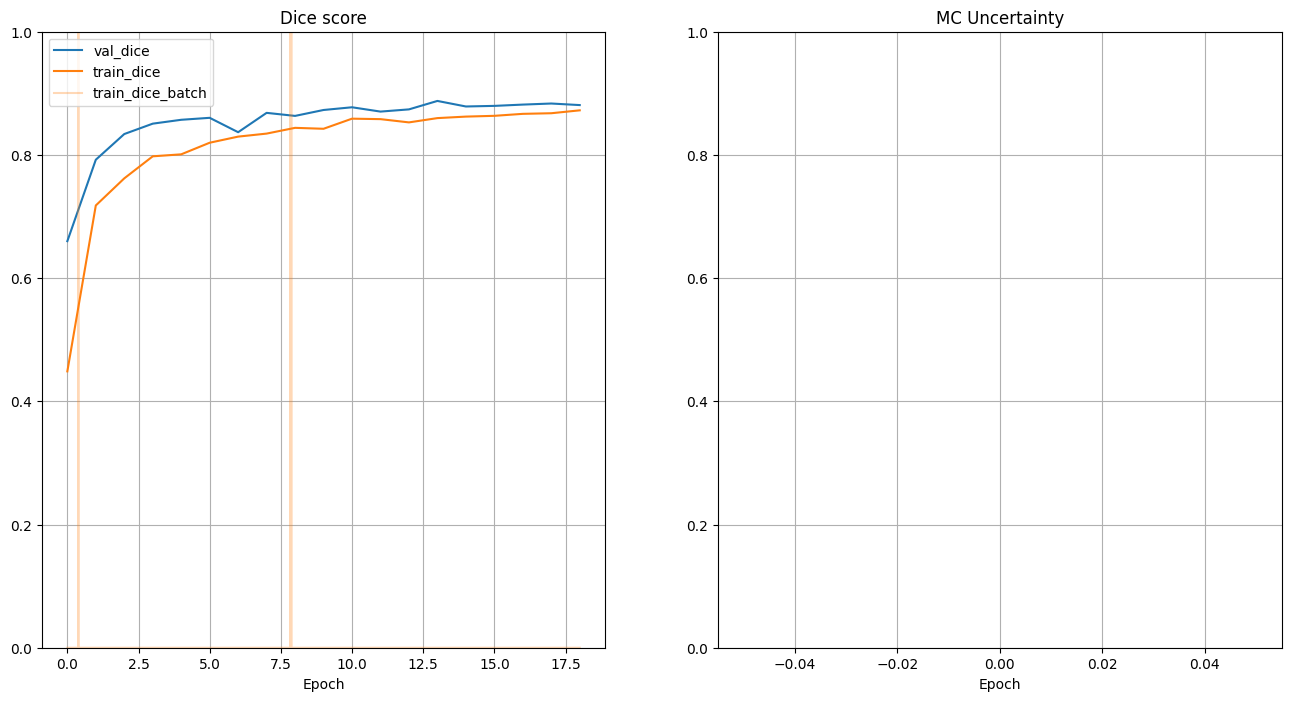


Epoch 19: val_loss did not improve from 0.03390
125/125 [==============================] - 31s 249ms/step - loss: 0.0364 - dice_coef: 0.8721 - val_loss: 0.0371 - val_dice_coef: 0.8809 - lr: 6.2500e-04
Epoch 19: early stopping


In [8]:
history = unet.fit(gen_train, epochs=epochs, validation_data=gen_val, verbose=1, callbacks=callbacks)

In [8]:
unet = load_model(checkpoint_path, custom_objects={'FocalDiceLoss': FocalDiceLoss, 'dice_coef': dice_coef},compile=False)
unet.compile(loss=loss, metrics=dice_coef, optimizer=optimizer)

In [12]:
def dice_eval(gen):
    results = unet.evaluate(gen, return_dict=True)
    dice = results["dice_coef"]
    print(f"Dice score: {dice:.2%}")

In [13]:
test_dice = dice_eval(gen_test)

 2/15 [===>..........................] - ETA: 0s - loss: 0.0837 - dice_coef: 0.7562

/home/thjo/miniconda3/envs/tf2/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


15/15 [==============================] - 1s 62ms/step - loss: 0.0693 - dice_coef: 0.7789
Dice score: 77.89%


In [12]:
val_dice = dice_eval(gen_val)

 2/15 [===>..........................] - ETA: 0s - loss: 0.0380 - dice_coef: 0.8734

/home/thjo/miniconda3/envs/tf2/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


15/15 [==============================] - 7s 460ms/step - loss: 0.0340 - dice_coef: 0.8871
Dice score: 8.87e-01


In [13]:
train_dice = dice_eval(gen_train)

125/125 [==============================] - 83s 669ms/step - loss: 0.0492 - dice_coef: 0.8385
Dice score: 8.38e-01


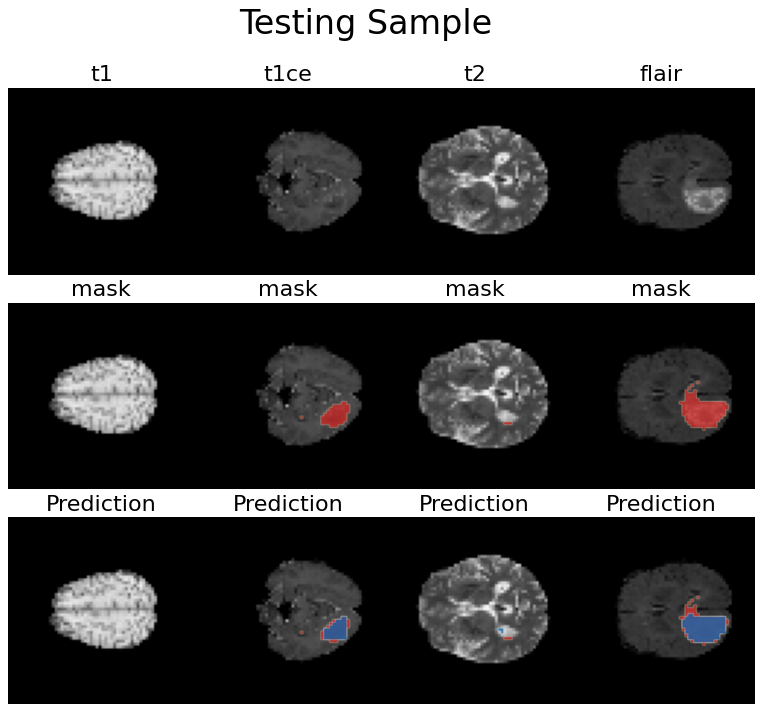

In [14]:
plot_sample(gen_test, array_labels, model=unet, batch_idx=None, save=False, title=f"Testing Sample")

In [16]:
from uncertainty.monte_carlo_dropout import MonteCarloDropoutModel
from utils.visualizations import plot_predictions
monte_carlo_model = MonteCarloDropoutModel(unet)

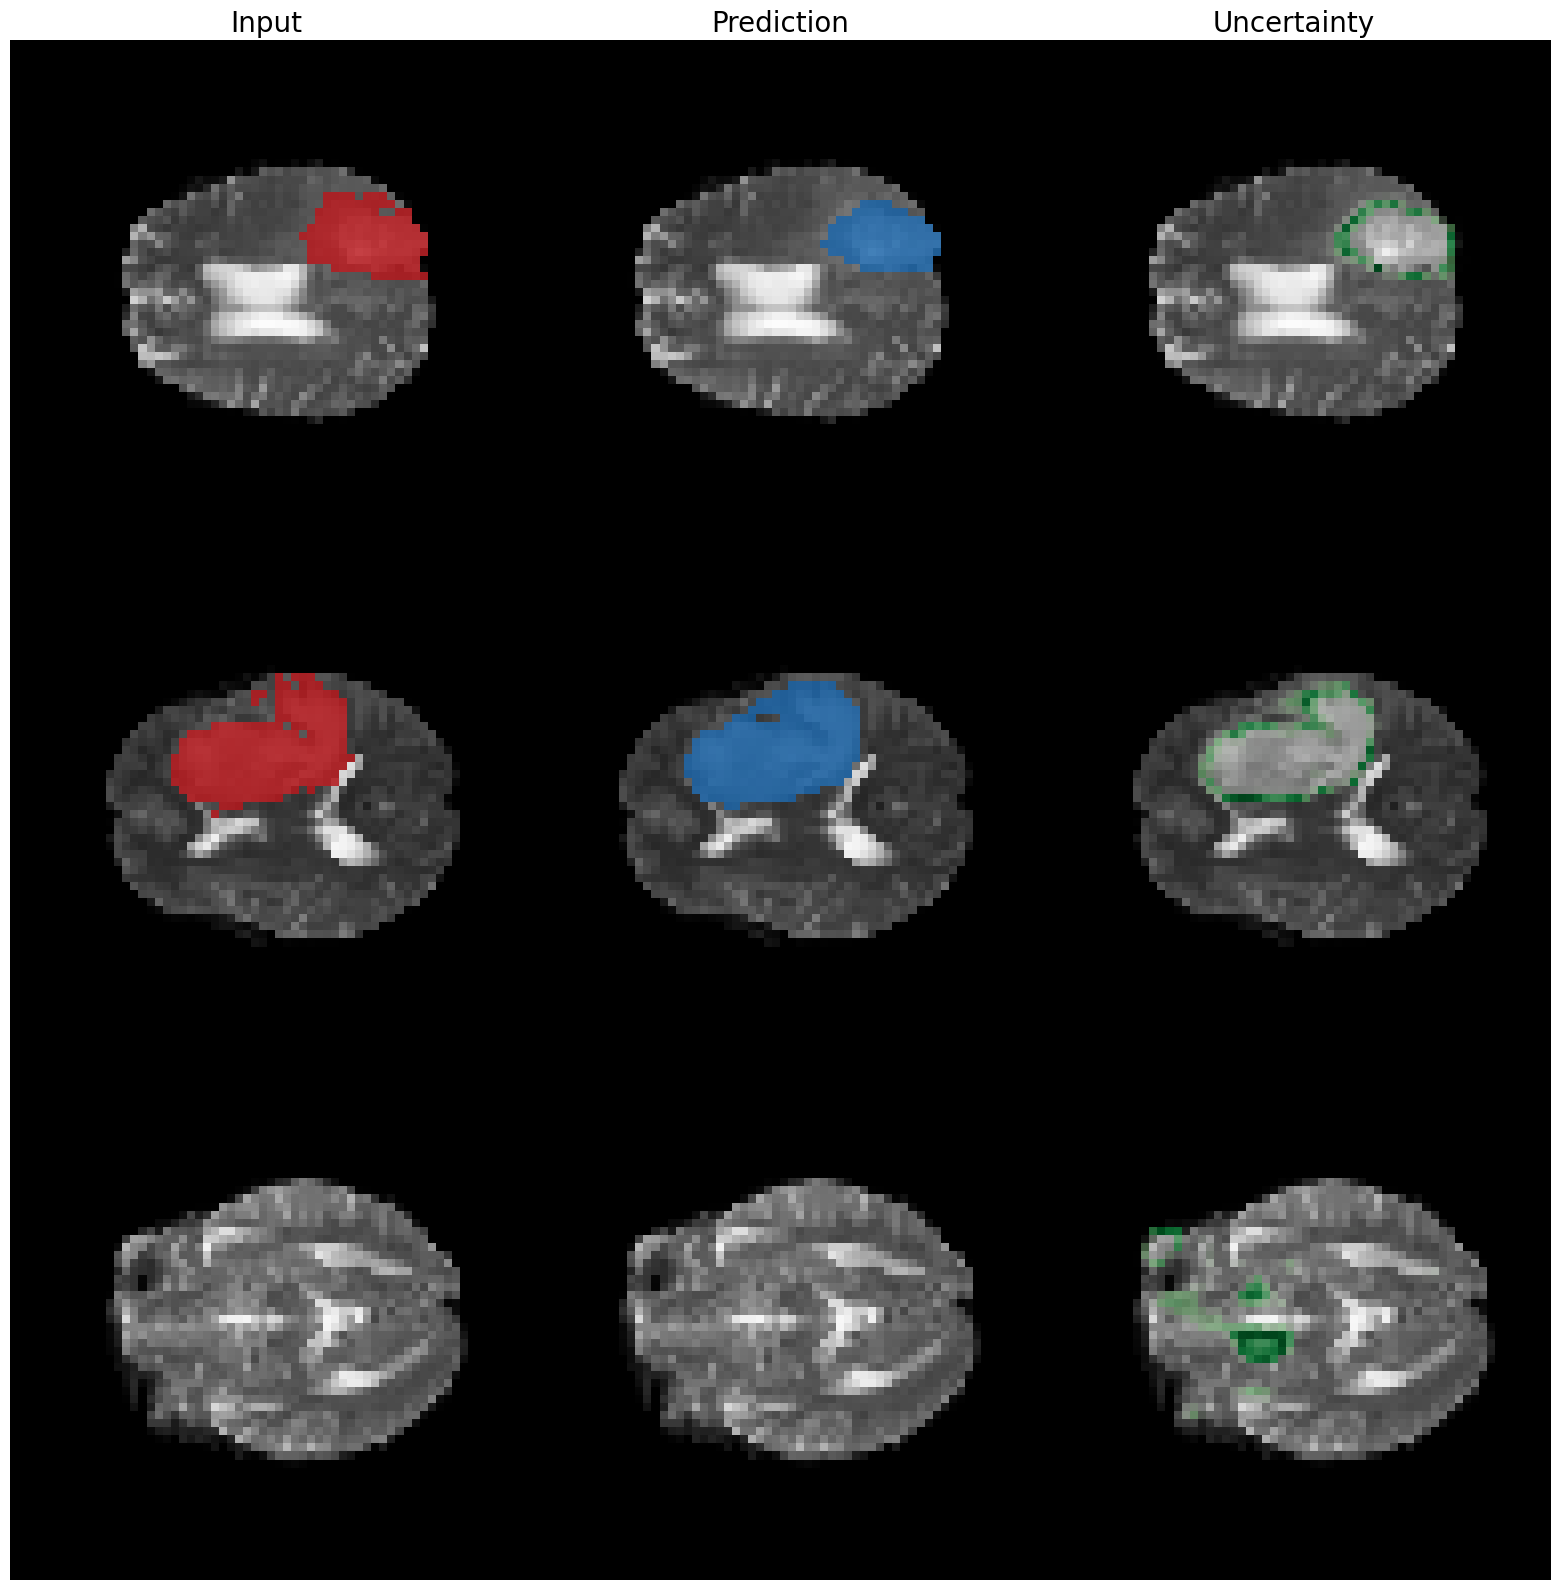

In [17]:
plot_predictions(gen_val, n=3, model=unet, unc_model=monte_carlo_model, title="Validation Samples")

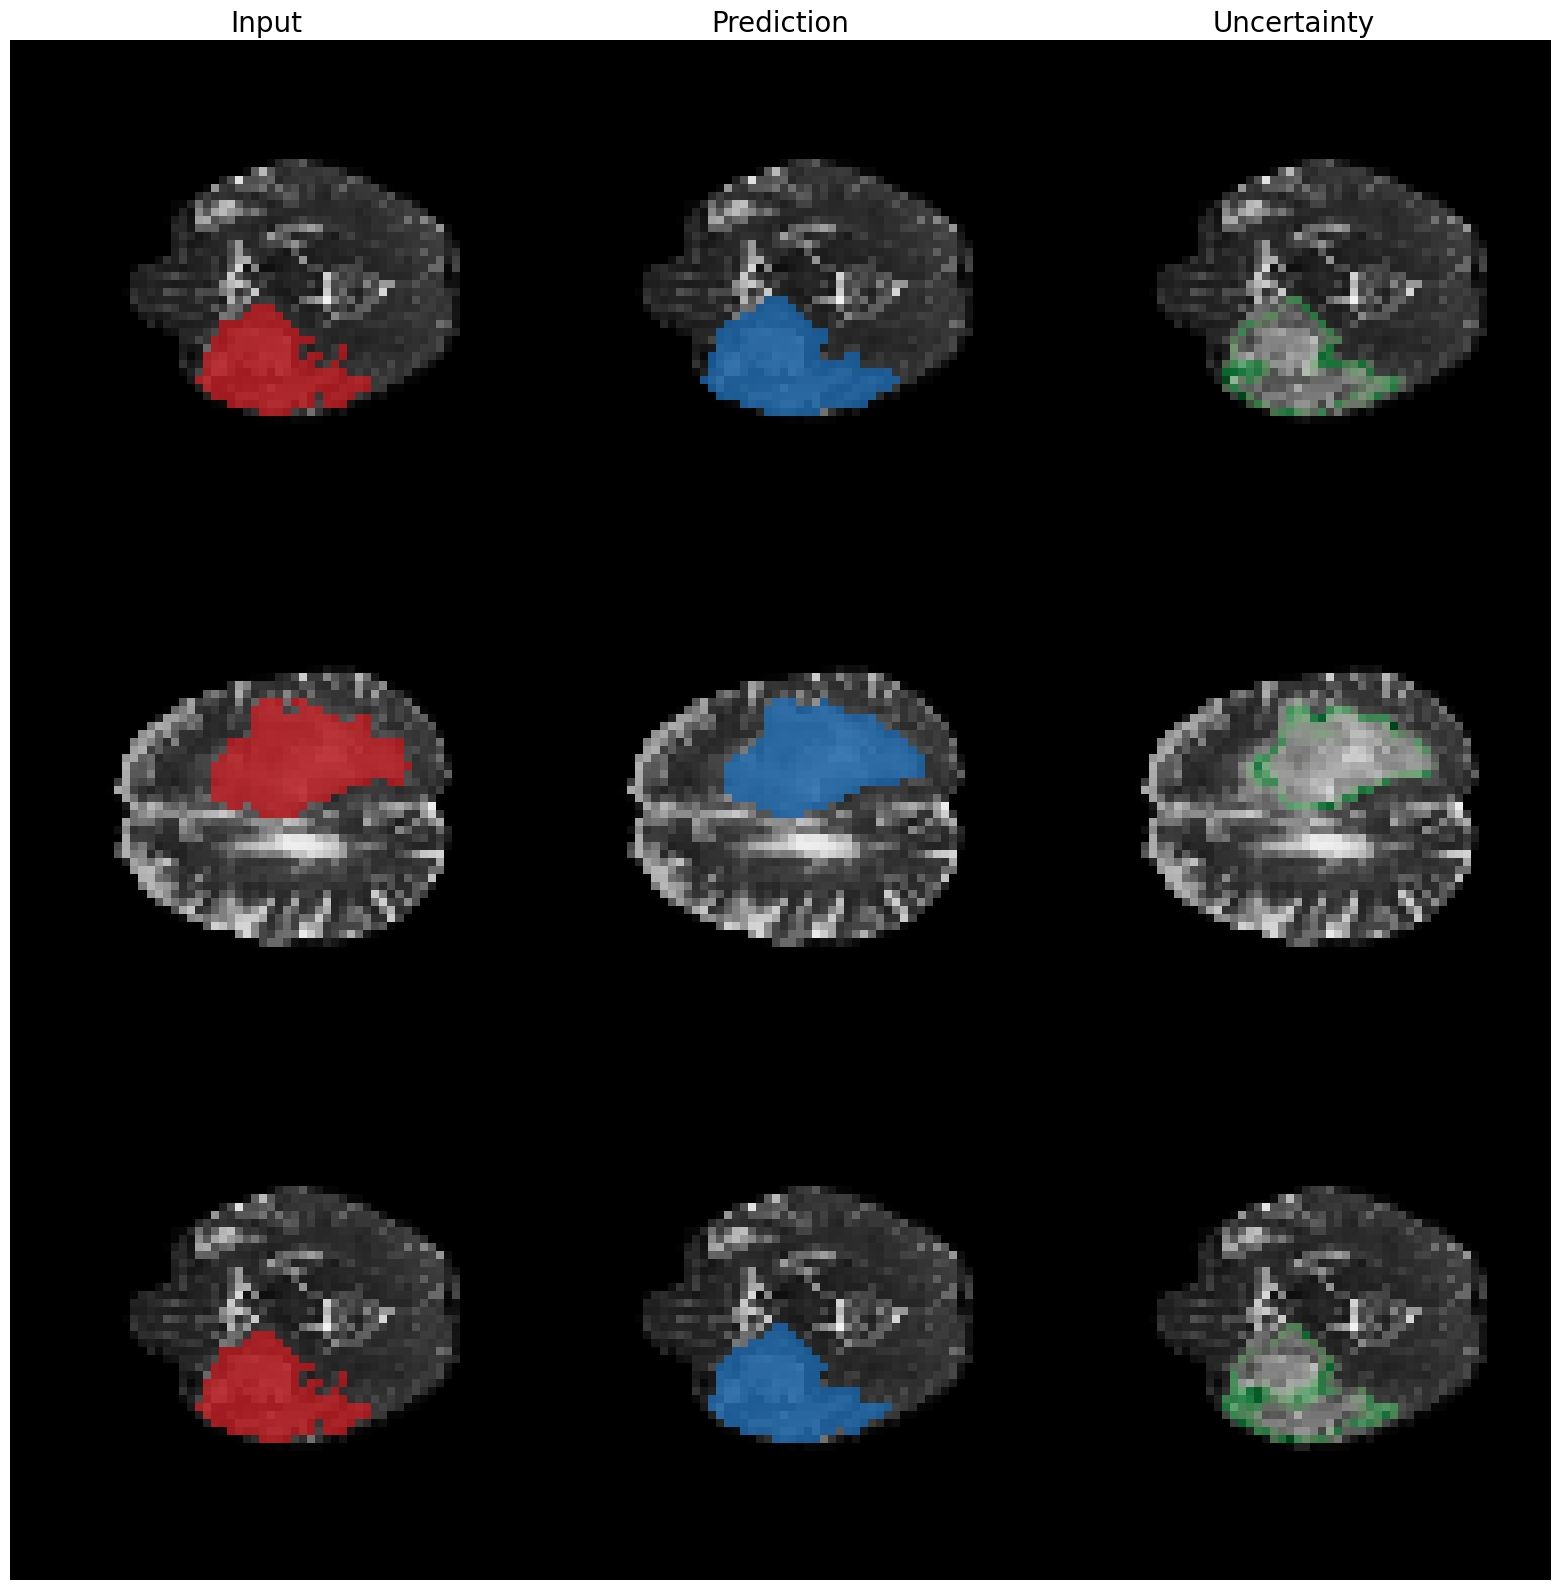

In [22]:
plot_predictions(gen_test, n=3, model=unet, unc_model=monte_carlo_model, title="Testing Samples")

In [15]:
def extract_data(data):
    """Stack all the data in a single array"""
    all_inputs = []
    all_masks = []
    for idx, (inputs, mask) in tqdm(enumerate(data), desc=f"Extracting {data.data_path}"): # Add the additional inputs inside the brackets
        all_inputs.append(inputs)
        all_masks.append(mask)
    all_inputs = np.concatenate(all_inputs, axis=0)
    all_masks = np.concatenate(all_masks, axis=0)
    return all_inputs, all_masks
all_train, all_train_masks = extract_data(gen_train)
all_val, all_val_masks = extract_data(gen_val)
all_test, all_test_masks = extract_data(gen_test)

Extracting /home/thjo/Datasets/Brats/training: 125it [00:01, 99.15it/s]


: 

: 

In [ ]:
def analysis_dataset(all_data:np.ndarray, all_masks:np.ndarray, title:str):
    mean_data_img = np.mean(all_train, axis=(0))
    n_channels = mean_data_img.shape[-1]
    mean_masks_img = np.mean(all_masks, axis=(0))
    mean_data = np.mean(all_train, axis=(0, 1, 2))
    mean_mask = float(np.mean(all_masks, axis=(0, 1, 2)))
    std_data_img = np.std(all_train, axis=(0))
    std_masks_img = np.std(all_masks, axis=(0))
    std_data = np.std(all_train, axis=(0, 1, 2))
    std_mask = float(np.std(all_masks, axis=(0, 1, 2)))

    print(f"Mean {title} inputs:")
    for channel in range(n_channels):
        print(f"Channel {channel}: {mean_data[channel]:.2e} +- {std_data[channel]:.2e}")
    print(f"Mean of {title} mask: {mean_mask:.2e} +- {std_mask:.2e}")
    return mean_data_img, mean_masks_img, std_data_img, std_masks_img

In [ ]:
mean_train_data_img, mean_train_masks_img, std_train_data_img, std_train_masks_img = analysis_dataset(all_train, all_train_masks, "training")
mean_val_data_img, mean_val_masks_img, std_val_data_img, std_val_masks_img = analysis_dataset(all_val, all_val_masks, "validation")
mean_test_data_img, mean_test_masks_img, std_test_data_img, std_test_masks_img = analysis_dataset(all_test, all_test_masks, "testing")


Mean training inputs:
Channel 0: 1.47e-01 +- 2.75e-01
Channel 1: 9.13e-02 +- 1.77e-01
Channel 2: 9.23e-02 +- 1.79e-01
Channel 3: 1.09e-01 +- 2.14e-01
Mean of training mask: 1.68e-02 +- 1.28e-01
Mean validation inputs:
Channel 0: 1.47e-01 +- 2.75e-01
Channel 1: 9.13e-02 +- 1.77e-01
Channel 2: 9.23e-02 +- 1.79e-01
Channel 3: 1.09e-01 +- 2.14e-01
Mean of validation mask: 2.11e-02 +- 1.44e-01
Mean testing inputs:
Channel 0: 1.47e-01 +- 2.75e-01
Channel 1: 9.13e-02 +- 1.77e-01
Channel 2: 9.23e-02 +- 1.79e-01
Channel 3: 1.09e-01 +- 2.14e-01
Mean of testing mask: 1.47e-02 +- 1.20e-01


In [ ]:
fig,axs = plt.subplots(2,3,figsize=(16,8),dpi=100)
axs[0,0].imshow(mean_train_data_img[...,0],cmap='gray',vmin=0,vmax=1)
axs[0,0].set_title('Mean training input',fontsize=20)
axs[0,1].imshow(mean_val_data_img[...,0],cmap='gray',vmin=0,vmax=1)
axs[0,1].set_title('Mean validation input',fontsize=20)
axs[0,2].imshow(mean_test_data_img[...,0],cmap='gray',vmin=0,vmax=1)
axs[0,2].set_title('Mean testing input',fontsize=20)
axs[1,0].imshow(std_train_data_img[...,0],cmap='gray',vmin=0,vmax=1)
axs[1,0].set_title('Std training input',fontsize=20)
axs[1,1].imshow(std_val_data_img[...,0],cmap='gray',vmin=0,vmax=1)
axs[1,1].set_title('Std validation input',fontsize=20)
axs[1,2].imshow(std_test_data_img[...,0],cmap='gray',vmin=0,vmax=1)
axs[1,2].set_title('Std testing input',fontsize=20)
plt.show()

NameError: name 'plt' is not defined

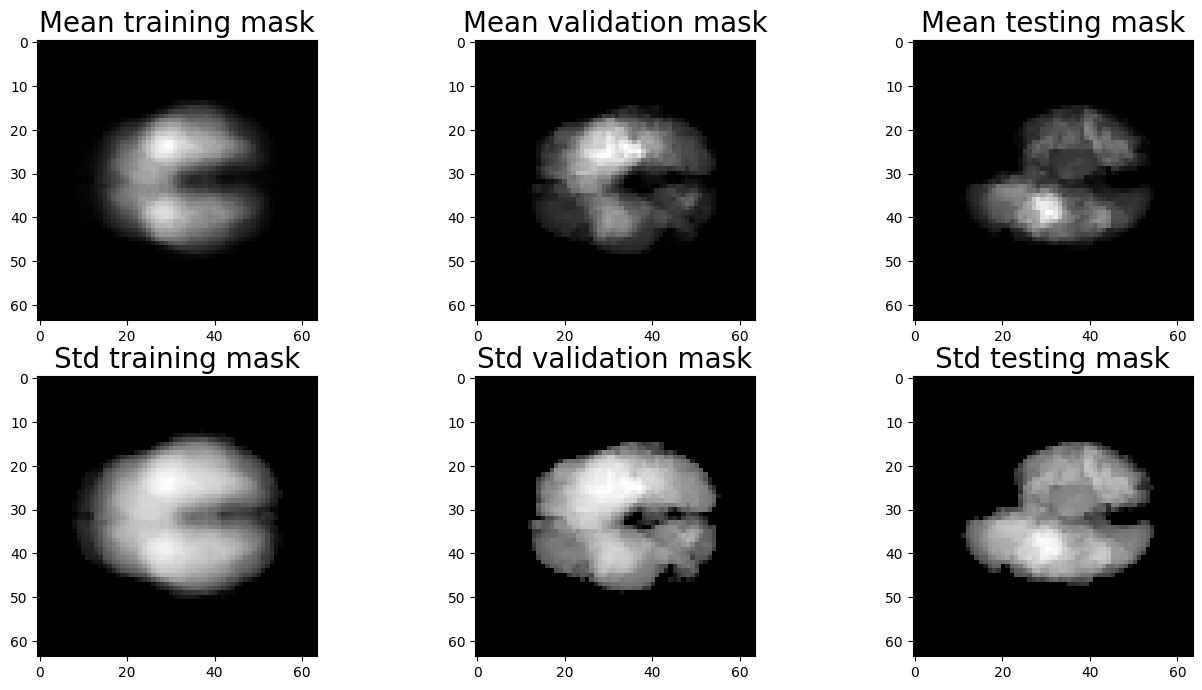

In [ ]:
def normalize(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img))
fig,axs = plt.subplots(2,3,figsize=(16,8),dpi=100)
axs[0,0].imshow(normalize(mean_train_masks_img[...,0]),cmap='gray',vmin=0,vmax=1)
axs[0,0].set_title('Mean training mask',fontsize=20)
axs[0,1].imshow(normalize(mean_val_masks_img[...,0]),cmap='gray',vmin=0,vmax=1)
axs[0,1].set_title('Mean validation mask',fontsize=20)
axs[0,2].imshow(normalize(mean_test_masks_img[...,0]),cmap='gray',vmin=0,vmax=1)
axs[0,2].set_title('Mean testing mask',fontsize=20)
axs[1,0].imshow(normalize(std_train_masks_img[...,0]),cmap='gray',vmin=0,vmax=1)
axs[1,0].set_title('Std training mask',fontsize=20)
axs[1,1].imshow(normalize(std_val_masks_img[...,0]),cmap='gray',vmin=0,vmax=1)
axs[1,1].set_title('Std validation mask',fontsize=20)
axs[1,2].imshow(normalize(std_test_masks_img[...,0]),cmap='gray',vmin=0,vmax=1)
axs[1,2].set_title('Std testing mask',fontsize=20)
plt.show()


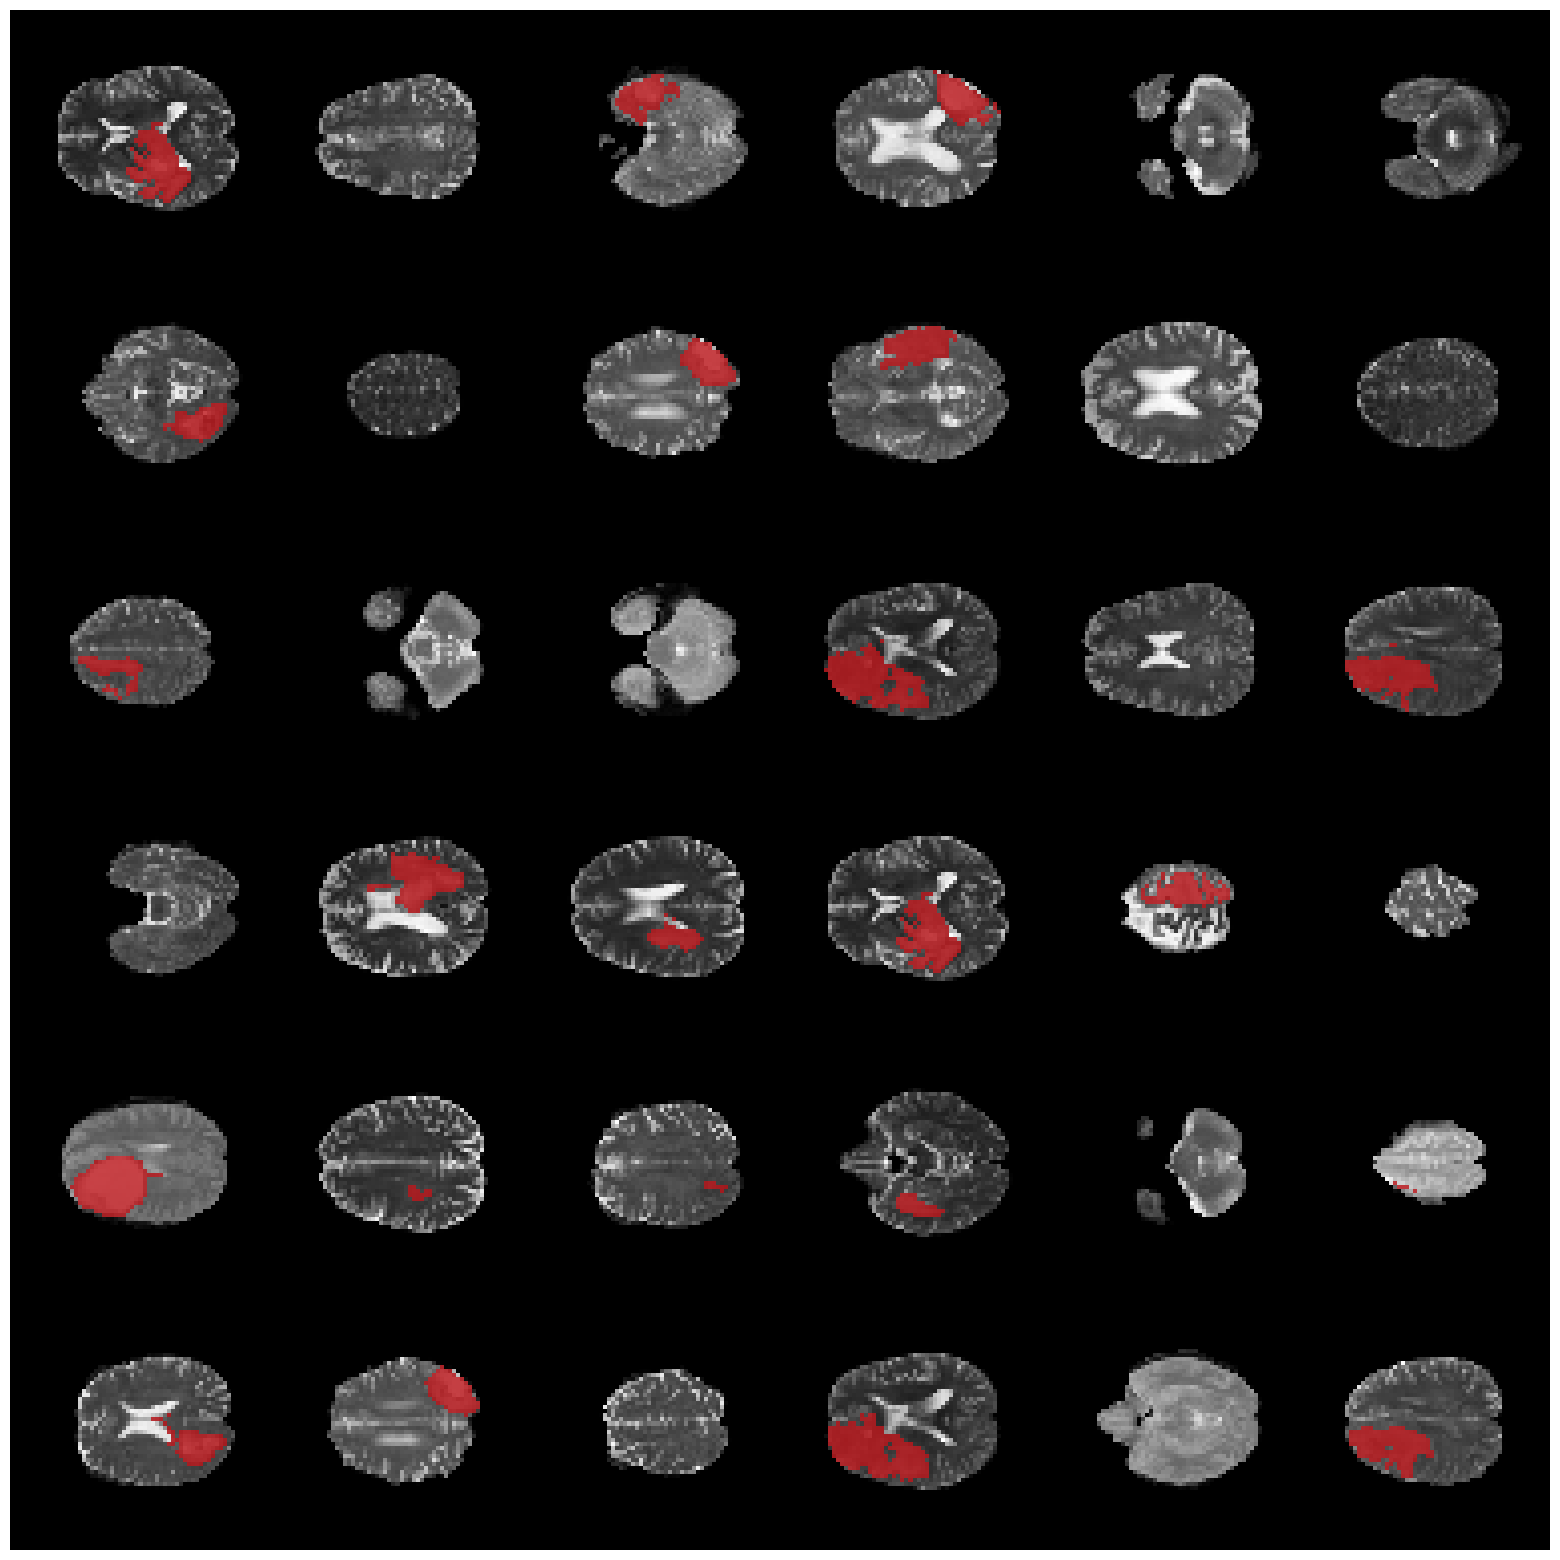

In [ ]:
plot_predictions((all_test,all_test_masks), n=36, title="Test Samples")

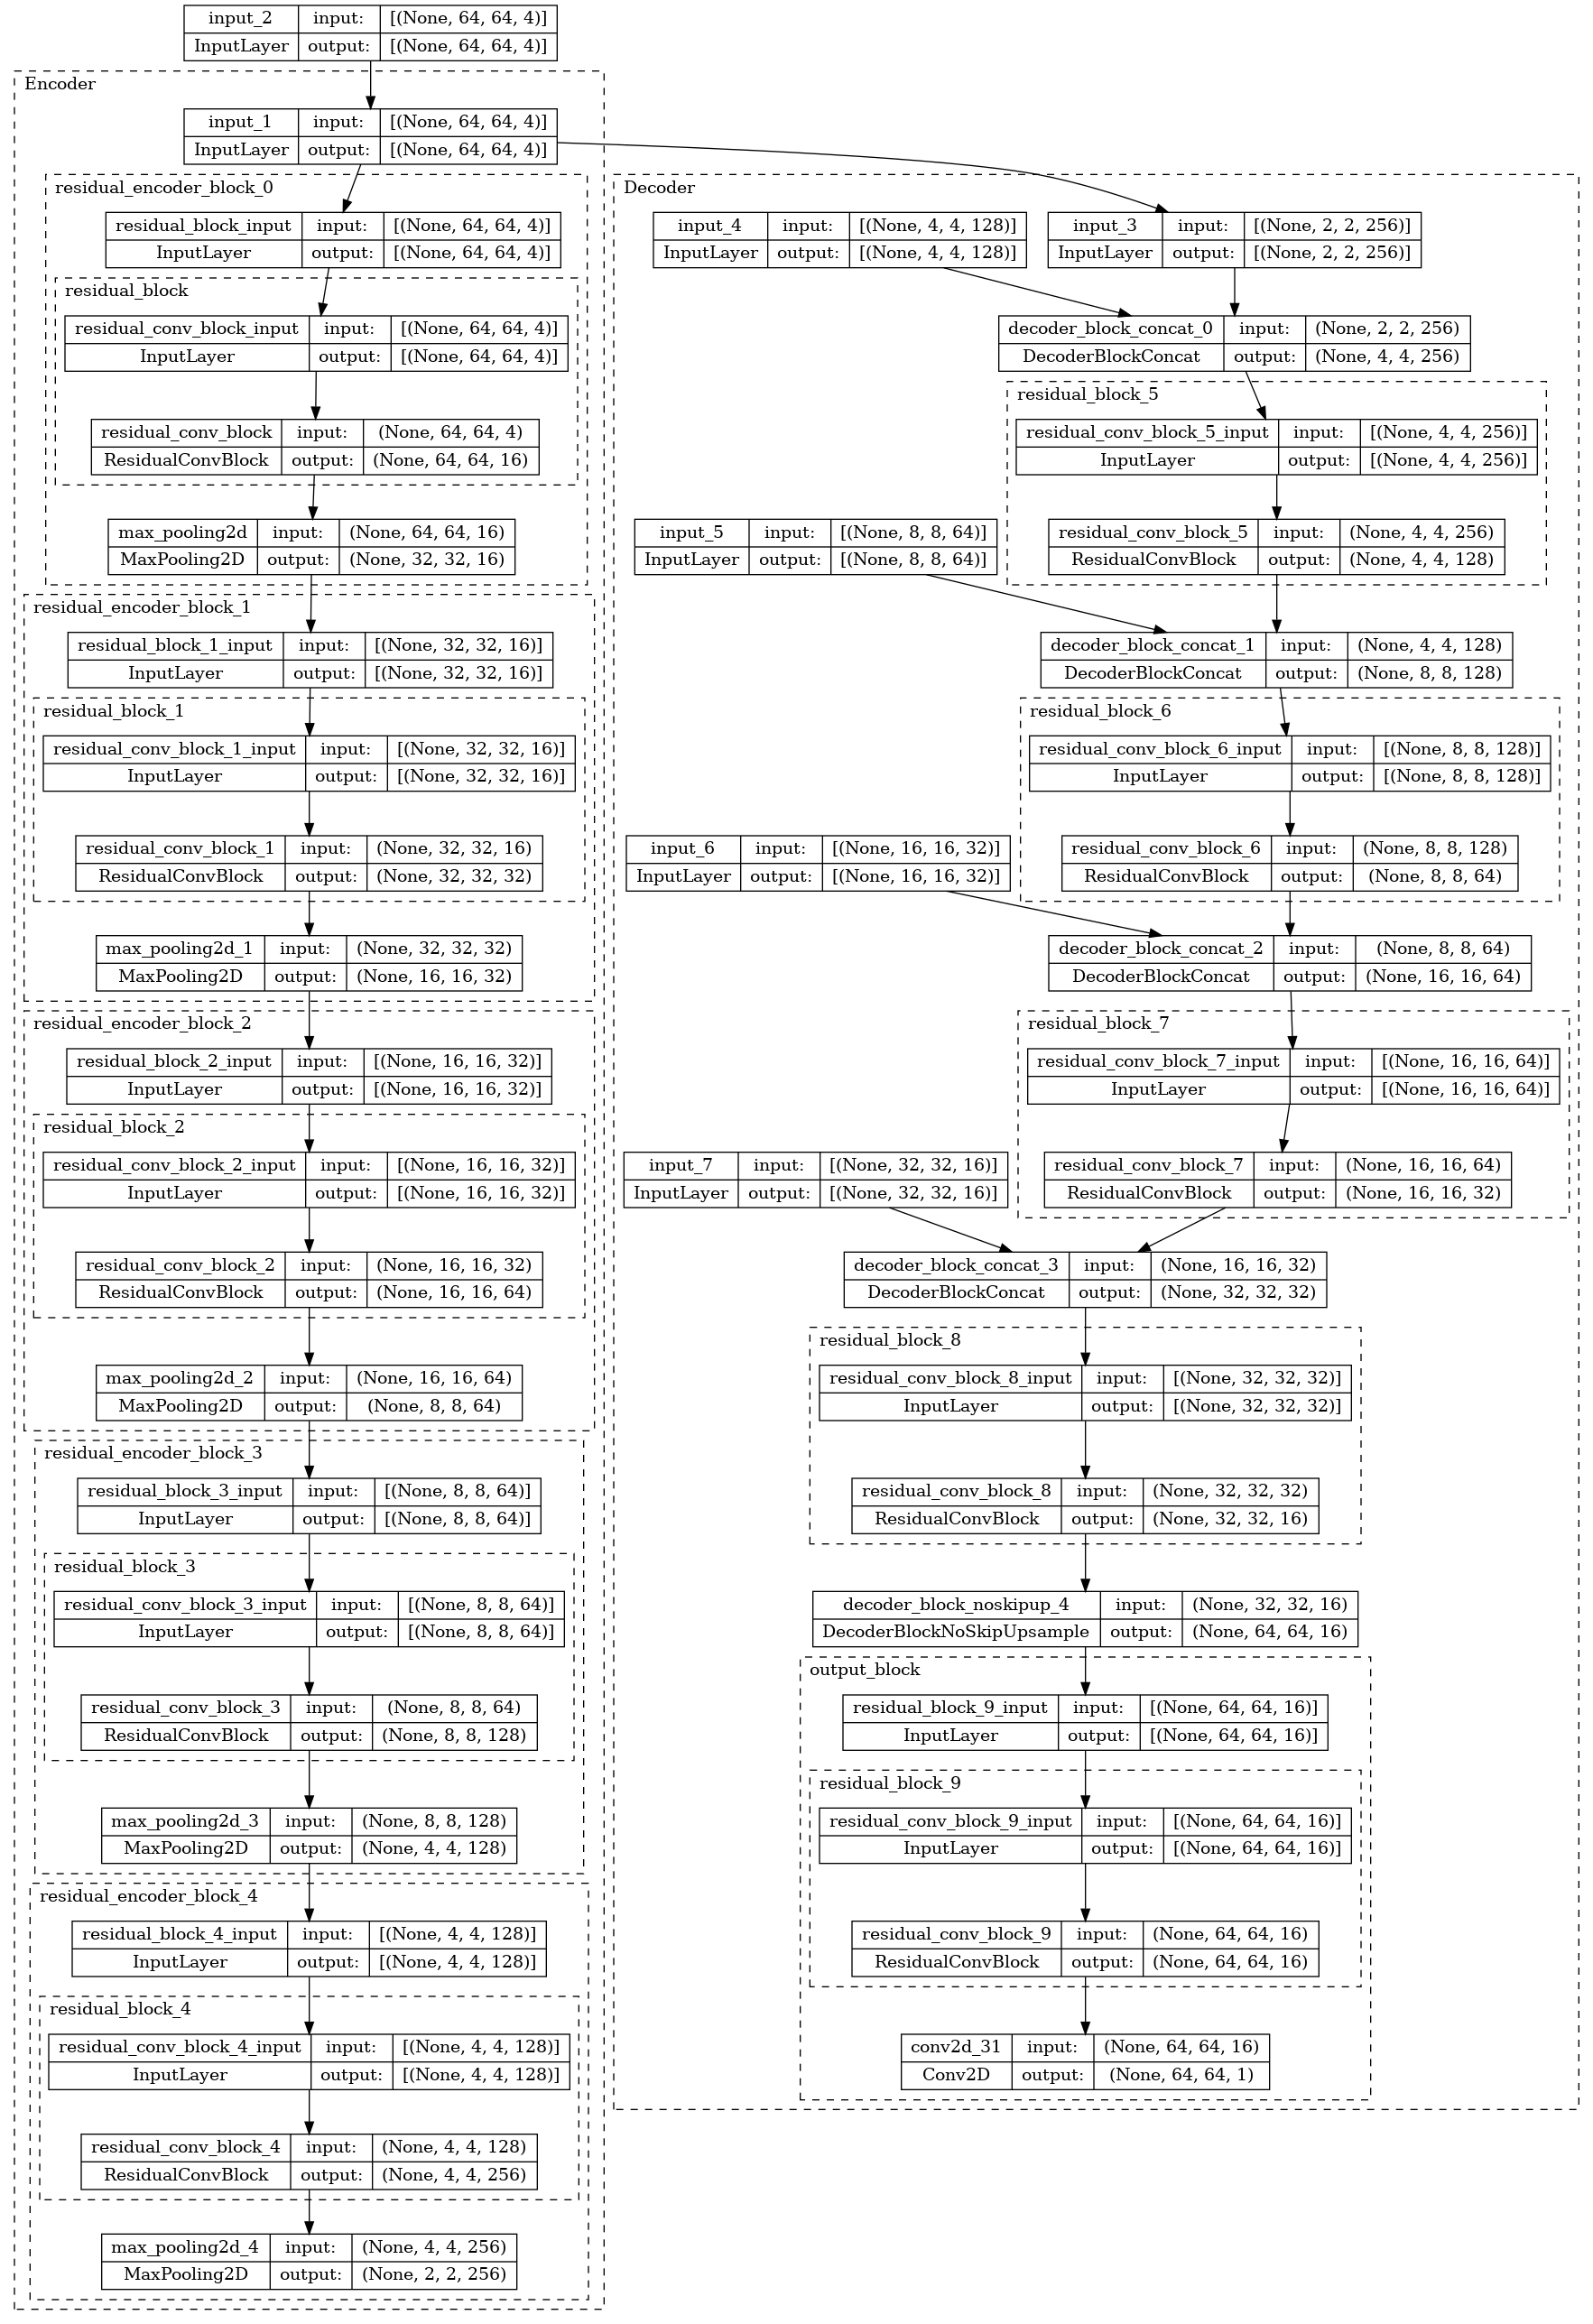

In [ ]:
plot_model(unet, to_file=os.path.join(figure_path, "unet.png"), show_shapes=True, show_layer_names=True,expand_nested=True)